<a href="https://colab.research.google.com/github/ZakiyQirosM/GLAURA-model/blob/main/glaura_seq_modelv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GLAURA**

**GLAURA** is an advanced Artificial Intelligence(AI) model powered by *Convolutional Neural Networks*(CNN), specifically designed to identify and classify retinal images as either glaucomatous or healthy. By deep learning techniques, **GLAURA** analyzes complex patterns and features within retinal scans that are often challenging for the human eye to discern. This model is envisioned to serve as a reliable diagnostic tool for ophthalmologists, providing accurate and timely insights to support clinical decision-making. Its development focuses on enhancing early detection of glaucoma—a leading cause of irreversible blindness—thereby contributing to improved patient care and preventative eye health strategies. With its robust architecture, **GLAURA** represents a significant step forward in the integration of AI into the field of medical imaging and ophthalmology. Developed as a final project for the `MSIB Batch-7 Independent Study Program` at `Startup Campus: Track Artificial Intelligence`, **GLAURA** leverages deep learning to analyze intricate retinal patterns, enhancing diagnostic precision and supporting preventative eye care strategies.

## Import libraries

In [ ]:
import zipfile
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np
import seaborn as sns
import cv2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "2"

## Read Dataset

In [ ]:
dataset_path = '/kaggle/input/glaucoma-dataset-eyepacs-airogs-light-v2/eyepac-light-v2-512-jpg'

for main_folder in ['train', 'test', 'validation']:
    print(main_folder.upper())
    for sub_folder in ['RG', 'NRG']:
        folder_path = os.path.join(dataset_path, main_folder, sub_folder)
        num_files = len(os.listdir(folder_path))
        print(f"{sub_folder}: {num_files}")
    print("=================================")

TRAIN
RG: 4000
NRG: 4000
TEST
RG: 385
NRG: 385
VALIDATION
RG: 385
NRG: 385


## Data Loader and Preprocessing

In [ ]:
BATCH_SIZE = 8
IMG_SIZE = (512, 512)

# Constants for normalization
mean = [0.3569, 0.2273, 0.1467]
std = [0.2023, 0.1994, 0.210]

In [ ]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = (image - mean) / std
    return image, label

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, 'train'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, 'validation'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, 'test'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 8000 files belonging to 2 classes.
Found 770 files belonging to 2 classes.
Found 770 files belonging to 2 classes.


In [ ]:
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
validation_ds = validation_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

## Modeling

In [ ]:
def Models(input_shape=(512, 512, 3)):
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=input_shape),

        tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(1024, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(512, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(2048, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.GlobalAveragePooling2D(),

        tf.keras.layers.Dense(512, kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compiling model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

### Define model

In [ ]:
model = Models()

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 510, 510, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 510, 510, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 510, 510, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 508, 508, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 508, 508, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 508, 508, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 506, 506, 256)  │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 506, 506, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 506, 506, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 253, 253, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 251, 251, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 251, 251, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 251, 251, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 249, 249, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 249, 249, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 249, 249, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 247, 247, 512)  │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 247, 247, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 247, 247, 512)  │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 123, 123, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 121, 121, 256)  │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 121, 121, 256)  │             

 Total params: 22,940,481 (87.51 MB)

 Trainable params: 22,928,961 (87.47 MB)

 Non-trainable params: 11,520 (45.00 KB)

### Training Optimization

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)

In [ ]:
epochs = 50

## Training the Model

In [ ]:
with tf.device('/device:GPU:0'):
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=validation_ds,
        callbacks=[early_stopping_callback, lr_scheduler]
    )

Epoch 1/50


I0000 00:00:1733281005.932944    1229 service.cc:145] XLA service 0x7bfd20010dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733281005.933012    1229 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733281085.762889    1229 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_21', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 962s 875ms/step - accuracy: 0.5301 - loss: 0.9338 - val_accuracy: 0.5714 - val_loss: 0.7044 - learning_rate: 1.0000e-04
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 862s 862ms/step - accuracy: 0.5807 - loss: 0.6973 - val_accuracy: 0.6260 - val_loss: 0.6469 - learning_rate: 1.0000e-04
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 862s 862ms/step - accuracy: 0.6131 - loss: 0.6665 - val_accuracy: 0.6390 - val_loss: 0.6793 - learning_rate: 1.0000e-04
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 862s 861ms/step - accuracy: 0.6381 - loss: 0.6449 - val_accuracy: 0.6481 - val_loss: 0.6506 - learning_rate: 1.0000e-04
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 863s 863ms/step - accuracy: 0.6742 - loss: 0.6035 - val_accuracy: 0.6792 - val_loss: 0.5879 - learning_rate: 5.0000e-05
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 863s 863ms/step - accuracy: 0.6938 - loss: 0.5869 - val_accuracy: 0.6792 - val_loss: 0.5872 - learning_rate: 5.0000e-05
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━

## Visualize model train

Text(0, 0.5, 'Accuracy')

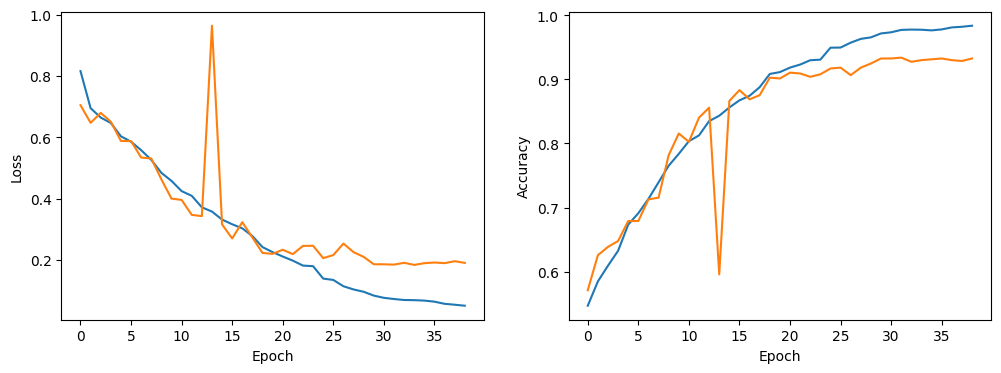

In [ ]:
# visualizes training loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# visualizes training accuracies
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

## Evaluate the Model with Test Data

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {accuracy * 100:.2f}%')

97/97 ━━━━━━━━━━━━━━━━━━━━ 27s 273ms/step - accuracy: 0.9121 - loss: 0.3029
Test accuracy: 92.08%


## Visulizes test Data

In [ ]:
# Helper model report
def evaluate_model(model, test_ds):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        predictions = model.predict(images, verbose=0)
        y_pred.extend(np.round(predictions).flatten())
        y_true.extend(labels.numpy().flatten())

    y_true = np.array(y_true, dtype=np.int32)
    y_pred = np.array(y_pred, dtype=np.int32)

    return y_true, y_pred

def generate_report(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["NRG", "RG"], yticklabels=["NRG", "RG"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    report = classification_report(y_true, y_pred, target_names=["NRG", "RG"])
    print("Classification Report:")
    print(report)


In [ ]:
y_true, y_pred = evaluate_model(model, test_ds)

Confusion Matrix:
[[351  34]
 [ 27 358]]


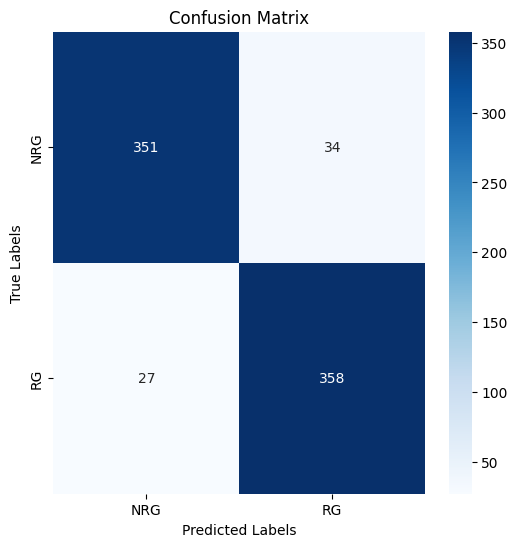

Classification Report:
              precision    recall  f1-score   support

         NRG       0.93      0.91      0.92       385
          RG       0.91      0.93      0.92       385

    accuracy                           0.92       770
   macro avg       0.92      0.92      0.92       770
weighted avg       0.92      0.92      0.92       770



In [ ]:
# Show model report
generate_report(y_true, y_pred)

## Save the Model

In [ ]:
model.save("GlauraSeqModel.keras")

In [ ]:
!pip freeze > requirements.txt